<a href="https://colab.research.google.com/github/FredrikBL/Spr-ktekProjekt/blob/main/Party_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DD1418 Project


This project uses texts from Swedish parties running for the general election starting from the year 1879, found [here](https://spraakbanken.gu.se/resurser/vivill). Five more texts were added to extend the available texts from the two least represented parties, the texts were collected from both parties' websites, [Centerpartiet](https://www.centerpartiet.se/vart-parti/partistamma-och-stammobeslut/2021), and [Socialdemokraterna](https://www.socialdemokraterna.se/var-politik/partiprogram-och-riktlinjer). The datapoints are then filtered below, and the corresponding text is then cleaned and prepared for training and testing. The cleaning of the text results in 4 train and test scenarios which are described further below. The four scenarios are then trained on three models. The final part of the project allows for any given text to be passed to the models for classification corresponding to one of eight classes (Parliament parties).

# Imports

In [ ]:
import numpy as np
import pandas as pd
import re
import requests
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical


!python -m spacy download sv_core_news_sm


# Parameters

In [2]:
nltk.download('punkt')

nltk.download('stopwords')
WORDS_TO_REMOVE = stopwords.words('swedish')

PARTIES_TO_KEEP = [
                    'Centerpartiet',
                    'Kristdemokraterna',
                    'Liberalerna',
                    'Moderaterna',
                    'Miljöpartiet de gröna',
                    'Socialdemokraterna',
                    'Sverigedemokraterna',
                    'Vänsterpartiet'
                   ]
PARTIES_TO_REMOVE = [
                      'Alliansen',
                      'Feministiskt initiativ',
                      'Piratpartiet',
                      'De rödgröna'
                     ]


WORDS_TO_REMOVE = stopwords.words('swedish')
PARTIES_TO_REMOVE_FROM_TEXT = PARTIES_TO_KEEP.copy()
PARTIES_TO_REMOVE_FROM_TEXT.extend(['Miljöpartiet', 'Folkpartiet', 'Centerparti', 'Vänsterparti', 'Miljöparti', 'Folkparti'])
WORDS_TO_REMOVE = WORDS_TO_REMOVE + [word.lower() for word in PARTIES_TO_REMOVE_FROM_TEXT] + [word.lower() + 's' for word in PARTIES_TO_REMOVE_FROM_TEXT]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Some of the party names and stopwords we want to remove from the text in the cleaning done below.

# Data Collection



In [3]:
excel_url = 'https://github.com/FredrikBL/Spr-ktekProjekt/raw/main/Partidokument.xlsx'

df = pd.read_excel(excel_url, engine='openpyxl')

print(df.shape)
df.head()

(354, 8)


,id,year,party_id,party,type_id,type,källa,titel
0,all-2006-v,2006,all,Alliansen,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,Fler i arbete - Mer att dela på. Valmanifest 2...
1,all-2010-v,2010,all,Alliansen,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,Jobbmanifestet. Alliansens valmanifest 2010-2014
2,all-2014-v,2014,all,Alliansen,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,Vi bygger Sverige - Alliansens valmanifest 201...
3,all-2018-r,2018,all,Alliansen,r,Reformagenda,Hämtat från partiets officiella hemsida.,Alliansens reformagenda
4,c-1912-p,1912,c,Centerpartiet,p,Partiprogram,Dokumentet är hämtat från riksdagens bibliotek.,Bondeförbundets program 1912


This dataframe shows an overview of the texts that are possible to collect.

In [ ]:
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

last_30_df = df[df['year'] >= 1993].copy()
last_30_df.loc[last_30_df['party'] == 'Folkpartiet liberalerna', 'party'] = 'Liberalerna'
last_30_df.loc[last_30_df['party_id'] == 'fp', 'party_id'] = 'l'
last_30_df.sort_values(by='party', ascending=True, inplace=True)
last_30_df = last_30_df[last_30_df['party'].isin(PARTIES_TO_KEEP)].reset_index()
last_30_df.loc[last_30_df['party'] == 'Miljöpartiet de gröna', 'party'] = 'Miljopartiet de grona'
last_30_df.loc[last_30_df['party'] == 'Vänsterpartiet', 'party'] = 'Vansterpartiet'

print(last_30_df.shape)
last_30_df


(124, 9)


,index,id,year,party_id,party,type_id,type,källa,titel
0,53,c-2022-v,2022,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,För Sveriges bästa - Valmanifest 2022
1,52,c-2021-ps3,2021,c,Centerpartiet,ps,Partistämma program,Hämtat från partiets officiella hemsida.,En starkare liberal demokrati
2,51,c-2021-ps2,2021,c,Centerpartiet,ps,Partistämma program,Hämtat från partiets officiella hemsida.,En grön ekonomi för fler företag och jobb
3,50,c-2021-ps1,2021,c,Centerpartiet,ps,Partistämma program,Hämtat från partiets officiella hemsida.,Vård och omsorg av hög kvalitet i hela landet
4,49,c-2018-v_eu,2018,c,Centerpartiet,v_eu,Valmanifest - Europaval,Hämtat från partiets officiella hemsida.,"Framåt för ett grönt, demokratiskt och frihetl..."
5,48,c-2018-v,2018,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,Nytt ledarskap för Sverige framåt - valmanifes...
6,47,c-2014-v_eu,2014,c,Centerpartiet,v_eu,Valmanifest - Europaval,Hämtat från partiets officiella hemsida.,Ett smalare men vassare EU
7,46,c-2014-v,2014,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,Sverige behöver närodlad politik
8,45,c-2013-i,2013,c,Centerpartiet,i,Idéprogram,Hämtat från partiets officiella hemsida.,En hållbar framtid - Våra idéer gör skillnad
9,44,c-2010-v,2010,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,Framtiden tillhör dem som vågar - Fler jobb i ...


Filters out the datapoints from the last 30 years for all parties currently in parliament. Renames some of the parties and changes instances of 'Folkpartiet' to 'Liberalerna'. Sorts the dataframe so party names are together.

## Text Collection & Data Visualization

Kinds of texts and amount
Valmanifest - Riksdagsval    61
Partiprogram                 24
Valmanifest - Europaval      17
Principprogram                7
Idéprogram                    5
Partistämma program           3
Handlingsprogram              3
Politiska Riktlinjer          2
Partiprogram - EU             1
Framtidsförslag               1
Name: type, dtype: int64



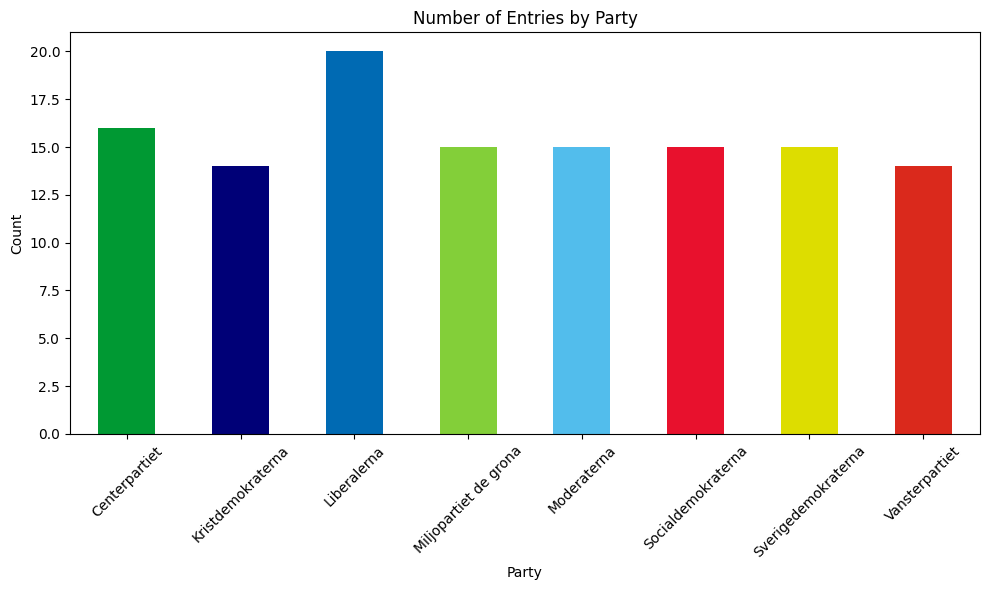

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:

print('Kinds of texts and amount')
type_counts = last_30_df['type'].value_counts()
print(type_counts)
print()

party_colors = {
                'Vansterpartiet' : "#DA291C",
                'Socialdemokraterna' : "#E8112d",
                'Miljopartiet de grona' : "#83CF39",
                'Centerpartiet' : "#009933",
                'Liberalerna' : "#006AB3",
                'Moderaterna' : "#52BDEC",
                'Kristdemokraterna' : "#000077",
                'Sverigedemokraterna' : "#DDDD00",
                }


plt.figure(figsize=(10, 6))

party_counts = last_30_df['party'].value_counts(sort=False)
party_counts.plot(kind='bar', color=[party_colors.get(party) for party in party_counts.index])

plt.title('Number of Entries by Party')
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))

category_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ffcc00', '#66ff66']

plt.figure(figsize=(10, 10))

labels = [f'{type_counts.index[i]}: {int(type_counts[i])}' for i in range(len(type_counts))]



The first print shows the number of different kinds of texts. The plot shows how many texts are available for each party.


In [ ]:
def get_files(sub_folder, file_name):

  file_url = f'https://raw.githubusercontent.com/FredrikBL/Spr-ktekProjekt/main/Partidokument/{sub_folder}/{file_name}.txt'
  response = requests.get(file_url)

  if response.status_code == 200:
        return response.text
  else:
        print(f"Failed to fetch content from {file_url}. Status code: {response.status_code}")
        return None

def get_text_chunks(text, chunk):
    chunks = []
    words = text.split()
    curr_chunk = words[0]

    for word in words[1:]:
        if len(curr_chunk) + len(word) + 1 <= chunk:
            curr_chunk += ' ' + word
        else:
            chunks.append(curr_chunk)
            curr_chunk = word

    chunks.append(curr_chunk)
    return chunks

def filter_rows_by_year(df_party):

    df_party_sorted = df_party.sort_values(by='year', ascending=False)

    df_party_filtered = df_party_sorted.head(min_party_count)

    return df_party_filtered


In [ ]:
text_df = last_30_df.copy()
text_df['text'] = text_df.apply(lambda row:get_files(row['party'], row['id']), axis=1)

new_rows = []

for index, row in text_df.iterrows():

    chunks = get_text_chunks(str(row['text']), 2500)

    for chunk in chunks:
        new_row = row.copy()
        new_row['text'] = chunk
        new_rows.append(new_row)

chunk_df = pd.DataFrame(new_rows)

min_party_count = chunk_df['party'].value_counts().min()

balanced_dfs = []
for party, group_df in chunk_df.groupby('party'):
    if len(group_df) >= min_party_count:
        party_balanced_df = filter_rows_by_year(group_df)
        balanced_dfs.append(party_balanced_df)

balanced_df = pd.concat(balanced_dfs)

balanced_df = balanced_df.reset_index(drop=True)

print(balanced_df.shape)
balanced_df


(2328, 10)


,index,id,year,party_id,party,type_id,type,källa,titel,text
0,53,c-2022-v,2022,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,För Sveriges bästa - Valmanifest 2022,FÖR SVERIGES BÄSTA VALMANIFEST 2022 Centerpart...
1,53,c-2022-v,2022,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,För Sveriges bästa - Valmanifest 2022,arbete för jobbsökare. Vi vill att det ska lön...
2,53,c-2022-v,2022,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,För Sveriges bästa - Valmanifest 2022,förutsättning för det. VI VILL GE KRAFT ÅT VAR...
3,53,c-2022-v,2022,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,För Sveriges bästa - Valmanifest 2022,"enkla lösningar för att lyckas med allt detta,..."
4,53,c-2022-v,2022,c,Centerpartiet,v,Valmanifest - Riksdagsval,Hämtat från partiets officiella hemsida.,För Sveriges bästa - Valmanifest 2022,dras in i krig. Ukrainas heroiska försvar av s...
...,...,...,...,...,...,...,...,...,...,...
2323,340,v-1993-c,1993,v,Vansterpartiet,c,Principprogram,"Inskannat från partiets egna tryckta material,...",För en solidarisk värld. Vänsterpartiets princ...,för en solidarisk värld PRINCIPPROGRAM ANTAGET...
2324,340,v-1993-c,1993,v,Vansterpartiet,c,Principprogram,"Inskannat från partiets egna tryckta material,...",För en solidarisk värld. Vänsterpartiets princ...,"och suppleanter, riksdagsgruppens ledamöter, r..."
2325,340,v-1993-c,1993,v,Vansterpartiet,c,Principprogram,"Inskannat från partiets egna tryckta material,...",För en solidarisk värld. Vänsterpartiets princ...,"inkomna motioner, riksdagsgruppens rapport, re..."
2326,340,v-1993-c,1993,v,Vansterpartiet,c,Principprogram,"Inskannat från partiets egna tryckta material,...",För en solidarisk värld. Vänsterpartiets princ...,"partiordförande, viceordföranden, partisekrete..."


Fetches all the .txt files corresponding to the file 'id' in the dataframe. As seen in the plot above each party only has a limited amount of texts but each text contains a lot of words. The texts are also of varying size, to resolve this and the limited amount of datapoints we decided to split the texts into chunks of specified character length, keeping the other row values intact. Datapoints from over-represented parties are removed ordered by year.

Kinds of texts and amount
Partiprogram                 694
Valmanifest - Riksdagsval    687
Valmanifest - Europaval      237
Principprogram               234
Framtidsförslag              117
Partistämma program           99
Idéprogram                    95
Politiska Riktlinjer          91
Handlingsprogram              40
Partiprogram - EU             34
Name: type, dtype: int64



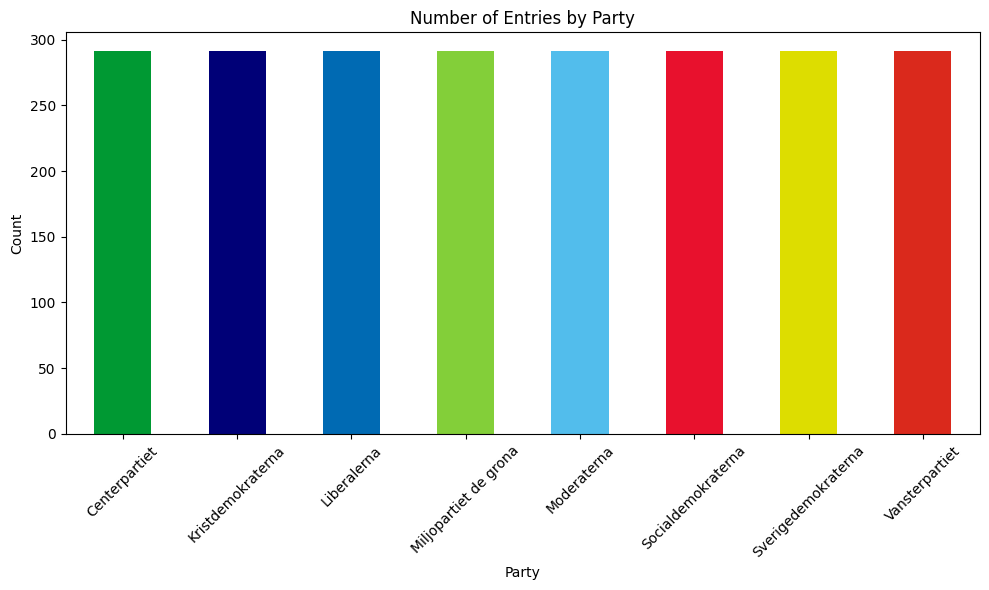

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:
print('Kinds of texts and amount')
type_counts = balanced_df['type'].value_counts()
print(type_counts)
print()

party_colors = {
                'Vansterpartiet' : "#DA291C",
                'Socialdemokraterna' : "#E8112d",
                'Miljopartiet de grona' : "#83CF39",
                'Centerpartiet' : "#009933",
                'Liberalerna' : "#006AB3",
                'Moderaterna' : "#52BDEC",
                'Kristdemokraterna' : "#000077",
                'Sverigedemokraterna' : "#DDDD00",
                }


plt.figure(figsize=(10, 6))

party_counts = balanced_df['party'].value_counts(sort=False)
party_counts.plot(kind='bar', color=[party_colors.get(party) for party in party_counts.index])

plt.title('Number of Entries by Party')
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))

category_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ffcc00', '#66ff66']

plt.figure(figsize=(10, 10))

labels = [f'{type_counts.index[i]}: {int(type_counts[i])}' for i in range(len(type_counts))]

Each party now has an equal amount of datapoints for training and testing later.

# Data Preparation

## Text Formatting & Lemmatization

We create two sets of cleaned texts one without lemmatization and one with

In [ ]:
def clean(text, lemma=False, wc=False):

    non_formatted_text = re.sub(r'[\x00-\x1F\x7F-\x9F\uFEFF]+', ' ', text)
    char_removed_text = re.sub(r'[^\w\s]+|\b\d+\b', '', non_formatted_text)

    if lemma:
        nlp = spacy.load('sv_core_news_sm')
        tokens = word_tokenize(char_removed_text)
        doc = nlp(' '.join(tokens).lower())
        lemmas = ' '.join([token.lemma_ for token in doc])
        lowercase_text = lemmas
    else:
        tokens = word_tokenize(char_removed_text)
        lowercase_text = ' '.join(tokens).lower()


    words_to_remove = [re.escape(word) for word in WORDS_TO_REMOVE]
    pattern = re.compile(r'\b(?:' + '|'.join(words_to_remove) + r')\b')
    words_removed_text = re.sub(pattern, '', lowercase_text)

    single_space_text = re.sub(r'\s+', ' ', words_removed_text)

    if wc:
        clean_text = single_space_text
    else:
        tokens = word_tokenize(single_space_text)
        clean_text = [token for token in tokens]

    return clean_text

The function uses regex in the first step to remove unnecessary formating characters; next step removes free standing numbers and special characters. Examples:

*   '\ufeffL\r\n\r\nPartiprogram' -> 'Partiprogram'
*   '1900-talet' -> 'talet'
*   '2022' -> ''
*   'Punkt1' -> 'Punkt1'

If lemmas are specified at time of call then the function creates lowercase lemmas using SpaCy with the 'sv_core_news_sm' corpus. If lemmas are'nt specified then the text is simply converted to lowercase.

Then stopwords and party names are removed and if that produces any double spacing between words then that is resolved.

Finally if clean was called from the wordcloud function then a string of the text is returned, if it was called during creation of tagged documents a list of the words in the text is returned.




In [ ]:
def create_wordcloud(df, party, cmap, ax):
    sel_rows = df[df['party'] == party]
    concat_text = ' '.join(sel_rows['text'].astype(str))

    clean_text = clean(concat_text, lemma=True, wc=True)

    wordcloud = WordCloud(width=600, height=300, background_color='white', colormap=cmap).generate(clean_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(party, fontsize=20)

making the wordclouds from lemmatized text from last election party specific.

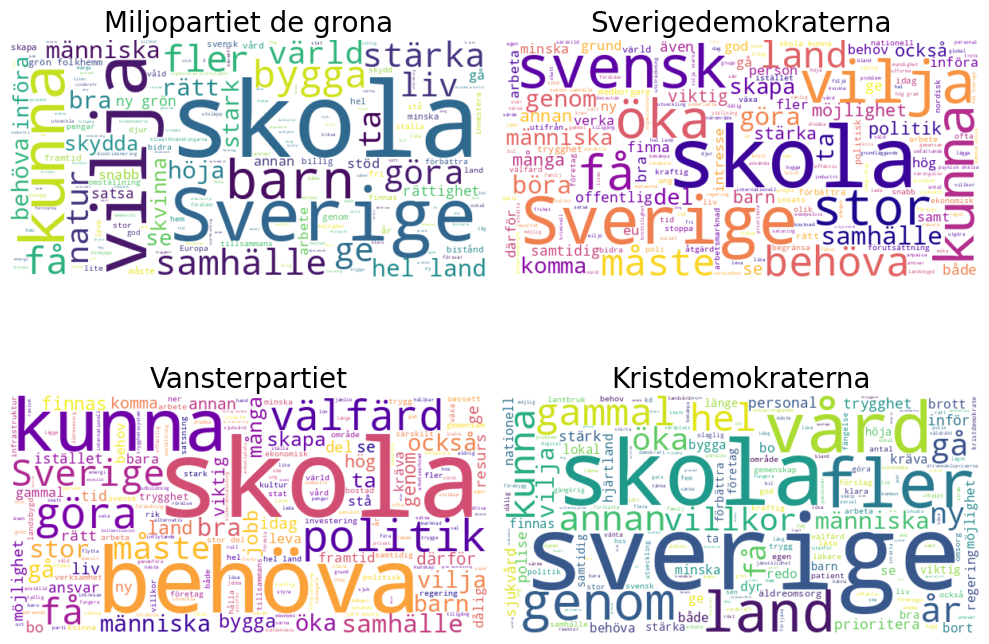

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

create_wordcloud(text_df[text_df['year'] == 2022], 'Miljopartiet de grona', 'viridis', axes[0, 0])
create_wordcloud(text_df[text_df['year'] == 2022], 'Sverigedemokraterna', 'plasma', axes[0, 1])
create_wordcloud(text_df[text_df['year'] == 2022], 'Vansterpartiet', 'plasma', axes[1, 0])
create_wordcloud(text_df[text_df['year'] == 2022], 'Kristdemokraterna', 'viridis', axes[1, 1])

plt.tight_layout()
plt.show()

## Vectorization

Creating nonlemma and lemma dfs from same train test split for comparison later. Creating tagged documents for Doc2Vec. Vectorization code adapted from this [article](https://medium.com/@danilo.najkov/detecting-political-bias-in-online-articles-using-nlp-and-classification-models-c1a40ec3989b).


In [ ]:
to_clean_df = balanced_df.copy()
to_clean_train, to_clean_test = train_test_split(to_clean_df, test_size=0.2, random_state=42)

nonlemma_train = to_clean_train.copy().reset_index(drop=True)
nonlemma_test = to_clean_test.copy().reset_index(drop=True)

lemma_train = to_clean_train.copy().reset_index(drop=True)
lemma_test = to_clean_test.copy().reset_index(drop=True)

nonlemma_train_tagged = nonlemma_train.apply(lambda row: TaggedDocument(words=clean(row['text']), tags=[row.party]), axis=1)
nonlemma_test_tagged = nonlemma_test.apply(lambda row: TaggedDocument(words=clean(row['text']), tags=[row.party]), axis=1)

lemma_train_tagged = lemma_train.apply(lambda row: TaggedDocument(words=clean(row['text'], lemma=True), tags=[row.party]), axis=1)
lemma_test_tagged = lemma_test.apply(lambda row: TaggedDocument(words=clean(row['text'], lemma=True), tags=[row.party]), axis=1)

Saving nonlemma and lemma models in two lists with both kinds of vectorization.

In [ ]:
nonlemma_models = [
    # PV-DBOW
    Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2),
    # PV-DM
    Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, sample=0, min_count=2)
]

lemma_models = [
    # PV-DBOW
    Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2),
    # PV-DM
    Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, sample=0, min_count=2)
]

Build the vocabulary, train, and save the models.

In [ ]:
for model in nonlemma_models:
    model.build_vocab(nonlemma_train_tagged.values)
    model.train(utils.shuffle(nonlemma_train_tagged.values), total_examples=len(nonlemma_train_tagged.values), epochs=30)

for model in lemma_models:
    model.build_vocab(lemma_train_tagged.values)
    model.train(utils.shuffle(lemma_train_tagged.values), total_examples=len(lemma_train_tagged.values), epochs=30)

Using the trained models, encode the text from the articles into vectors of length 300, saving them into a dictionary 'scenarios' for use later.

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return features, classes

scenarios = {}

# Nonlemma
# PV-DBOW encoded text
nonlemma_train_x_0, nonlemma_train_y_0 = vec_for_learning(nonlemma_models[0], nonlemma_train_tagged)
nonlemma_test_x_0, nonlemma_test_y_0 = vec_for_learning(nonlemma_models[0], nonlemma_test_tagged)
scenarios['nonlemma dbow train and test'] = [nonlemma_train_x_0, nonlemma_train_y_0, nonlemma_test_x_0, nonlemma_test_y_0]

# PV-DM encoded text
nonlemma_train_x_1, nonlemma_train_y_1 = vec_for_learning(nonlemma_models[1], nonlemma_train_tagged)
nonlemma_test_x_1, nonlemma_test_y_1 = vec_for_learning(nonlemma_models[1], nonlemma_test_tagged)
scenarios['nonlemma dm train and test'] = [nonlemma_train_x_1, nonlemma_train_y_1, nonlemma_test_x_1, nonlemma_test_y_1]

# Lemma
# PV-DBOW encoded text
lemma_train_x_0, lemma_train_y_0 = vec_for_learning(lemma_models[0], lemma_train_tagged)
lemma_test_x_0, lemma_test_y_0 = vec_for_learning(lemma_models[0], lemma_test_tagged)
scenarios['lemma dbow train and test'] = [lemma_train_x_0, lemma_train_y_0, lemma_test_x_0, lemma_test_y_0]

# PV-DM encoded text
lemma_train_x_1, lemma_train_y_1 = vec_for_learning(lemma_models[1], lemma_train_tagged)
lemma_test_x_1, lemma_test_y_1 = vec_for_learning(lemma_models[1], lemma_test_tagged)
scenarios['lemma dm train and test'] = [lemma_train_x_1, lemma_train_y_1, lemma_test_x_1, lemma_test_y_1]


# Models

Models defined in code here, and are trained tested and evaluated further down. The setup of each model is split into different functions to make training, testing, and evaluation easier but also to allow for out demo below.

## Naive Bayes

In [ ]:
def train_nb(X_train, y_train):

    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    return nb_model

def test_nb(nb_model, X_test, y_test='', demo=False):

    if demo:
        y_pred = nb_model.predict(X_test)
        y_pred_proba = nb_model.predict_proba(X_test)
        return y_pred[0], y_pred_proba.reshape(-1, 1)

    y_pred = nb_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=0.0)

    return y_pred, accuracy, class_report

def train_and_test_nb(scenarios):

    report_and_acc = {}
    nb_models = {}

    for key in scenarios:
        nb_model = train_nb(scenarios[key][0], scenarios[key][1])
        nb_models[key] = nb_model
        party_preds, accuracy, class_report = test_nb(nb_model, scenarios[key][2], scenarios[key][3])
        report_and_acc[key] = [party_preds, accuracy, class_report]

    eval_nb(scenarios, report_and_acc)

    return nb_models

def eval_nb(scenarios, report_and_acc):

    for key in report_and_acc:
        print(f'\n\n{key} Accuracy: {report_and_acc[key][1]}')
        print(f'\n{key} Classification Report:')
        print(report_and_acc[key][2])

        conf_matrix = confusion_matrix(scenarios[key][3], report_and_acc[key][0])
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=PARTIES_TO_KEEP, yticklabels=PARTIES_TO_KEEP)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Naive Bayes Confusion Matrix - {key}')
        plt.show()

## Random Forest

In [ ]:
def train_rf(X_train, y_train):

    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)

    return rf_model

def test_rf(rf_model, X_test, y_test='', demo=False):

    if demo:
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)
        return y_pred[0], y_pred_proba.reshape(-1, 1)

    y_pred = rf_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=0.0)

    return y_pred, accuracy, class_report

def train_and_test_rf(scenarios):

    report_and_acc = {}
    rf_models = {}

    for key in scenarios:
        rf_model = train_rf(scenarios[key][0], scenarios[key][1])
        rf_models[key] = rf_model
        party_preds, accuracy, class_report = test_rf(rf_model, scenarios[key][2], scenarios[key][3])
        report_and_acc[key] = [party_preds, accuracy, class_report]

    eval_rf(scenarios, report_and_acc)

    return rf_models

def eval_rf(scenarios, report_and_acc):

    for key in report_and_acc:
        print(f'\n\n{key} Accuracy: {report_and_acc[key][1]}')
        print(f'\n{key} Classification Report:')
        print(report_and_acc[key][2])

        conf_matrix = confusion_matrix(scenarios[key][3], report_and_acc[key][0])
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=PARTIES_TO_KEEP, yticklabels=PARTIES_TO_KEEP)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Random Forest Confusion Matrix - {key}')
        plt.show()

## Neural Network

In [ ]:

def train_nn(X_train, y_train, X_test, y_test, epochs):

    label_encoder = LabelEncoder()

    y_train_encoded = label_encoder.fit_transform(y_train)
    y_train_categorical = to_categorical(y_train_encoded)

    y_test_encoded = label_encoder.transform(y_test)
    y_test_categorical = to_categorical(y_test_encoded)

    nn_model = Sequential()
    nn_model.add(Dense(128, activation='relu', input_dim=len(X_train[0])))
    nn_model.add(Dense(96, activation='relu'))
    nn_model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

    nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = nn_model.fit(np.array(X_train), y_train_categorical, epochs=epochs,
                           validation_data=(np.array(X_test), y_test_categorical), verbose=0)

    return nn_model, label_encoder, history


def test_nn(nn_model, label_encoder, X_test, y_test='', demo=False):

    X_test = np.array(X_test)
    y_pred_proba = nn_model.predict(X_test)
    y_pred = label_encoder.inverse_transform(np.argmax(y_pred_proba, axis=1))

    if demo:
        return y_pred[0], y_pred_proba.reshape(-1, 1)
    else:
        return y_pred


def train_and_test_nn(scenarios, epochs):

    nn_models_and_decoders = {}
    preds_and_history = {}

    for key in scenarios:
        nn_model, label_encoder, history = train_nn(scenarios[key][0], scenarios[key][1],
                                                    scenarios[key][2], scenarios[key][3], epochs)
        nn_models_and_decoders[key] = [nn_model, label_encoder]

        predictions = test_nn(nn_model, label_encoder, scenarios[key][2], scenarios[key][3])
        preds_and_history[key] = [predictions, history]

    eval_nn(scenarios, preds_and_history)

    return nn_models_and_decoders


def eval_nn(scenarios, preds_and_history):

    for key in scenarios:
        y_test = scenarios[key][3]
        print(f'\n\n{key} Classification Report:')
        print(classification_report(y_test, preds_and_history[key][0]))

        conf_matrix = confusion_matrix(y_test, preds_and_history[key][0])
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=PARTIES_TO_KEEP, yticklabels=PARTIES_TO_KEEP)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Neural Network Confusion Matrix - {key}')
        plt.show()

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.plot(preds_and_history[key][1].history['loss'])
        plt.plot(preds_and_history[key][1].history['val_loss'])
        plt.title(f'Model {key} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper right')

        plt.subplot(1, 2, 2)
        plt.plot(preds_and_history[key][1].history['accuracy'])
        plt.plot(preds_and_history[key][1].history['val_accuracy'])
        plt.title(f'Model {key} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='lower right')

        plt.tight_layout()
        plt.show()


# Test Score & Evaluation

This part trains, tests, and evaluates the models on all four scenarios.



nonlemma dbow train and test Accuracy: 0.8776824034334764

nonlemma dbow train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.94      0.79      0.86        61
    Kristdemokraterna       0.86      0.82      0.84        67
          Liberalerna       0.98      0.91      0.94        53
Miljopartiet de grona       0.75      0.81      0.78        54
          Moderaterna       0.82      0.91      0.86        65
   Socialdemokraterna       0.89      0.91      0.90        56
  Sverigedemokraterna       0.91      0.94      0.92        62
       Vansterpartiet       0.92      0.96      0.94        48

             accuracy                           0.88       466
            macro avg       0.88      0.88      0.88       466
         weighted avg       0.88      0.88      0.88       466



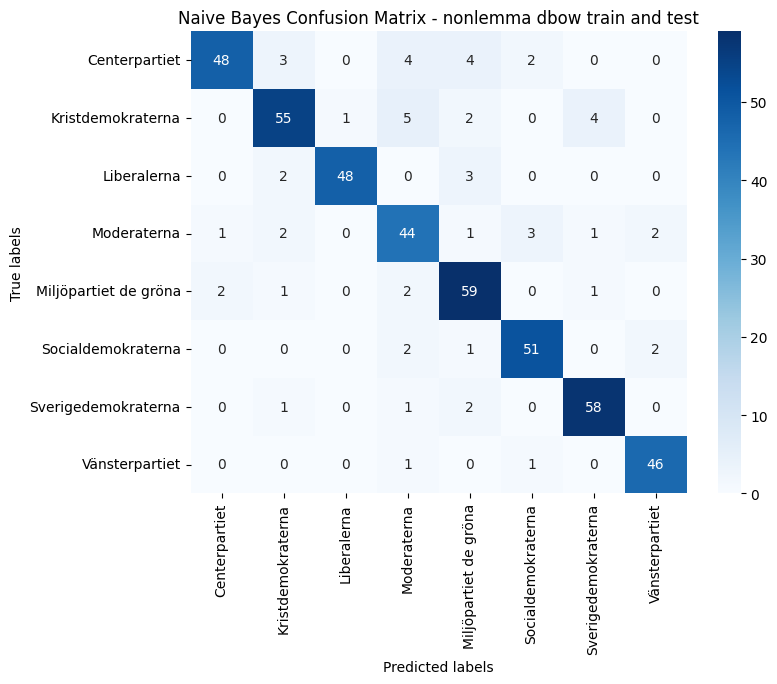



nonlemma dm train and test Accuracy: 0.7725321888412017

nonlemma dm train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.64      0.82      0.72        61
    Kristdemokraterna       1.00      0.45      0.62        67
          Liberalerna       1.00      0.72      0.84        53
Miljopartiet de grona       0.69      0.81      0.75        54
          Moderaterna       0.57      0.91      0.70        65
   Socialdemokraterna       0.83      0.80      0.82        56
  Sverigedemokraterna       0.96      0.87      0.92        62
       Vansterpartiet       0.93      0.83      0.88        48

             accuracy                           0.77       466
            macro avg       0.83      0.78      0.78       466
         weighted avg       0.83      0.77      0.77       466



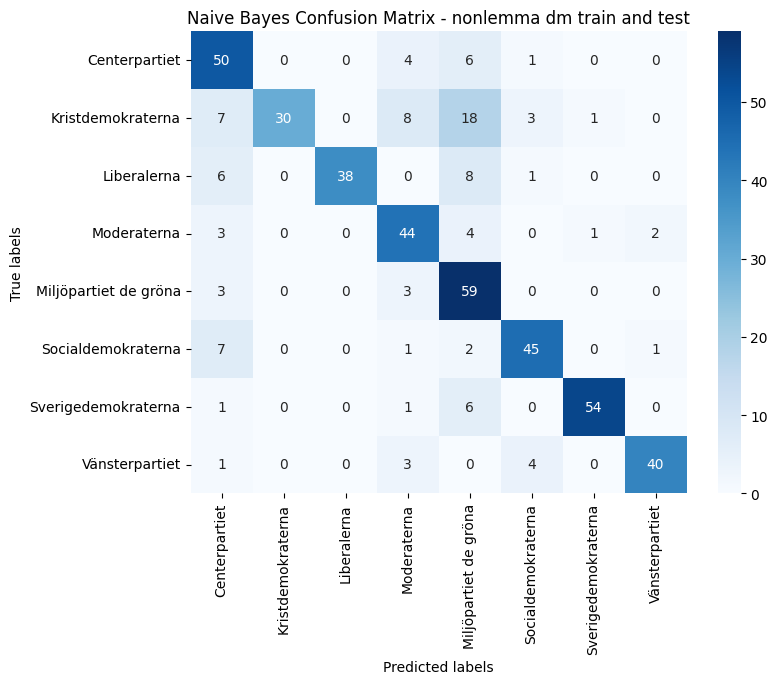



lemma dbow train and test Accuracy: 0.8648068669527897

lemma dbow train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.87      0.77      0.82        61
    Kristdemokraterna       0.93      0.79      0.85        67
          Liberalerna       0.96      0.94      0.95        53
Miljopartiet de grona       0.72      0.78      0.75        54
          Moderaterna       0.81      0.94      0.87        65
   Socialdemokraterna       0.96      0.84      0.90        56
  Sverigedemokraterna       0.88      0.92      0.90        62
       Vansterpartiet       0.82      0.96      0.88        48

             accuracy                           0.86       466
            macro avg       0.87      0.87      0.87       466
         weighted avg       0.87      0.86      0.86       466



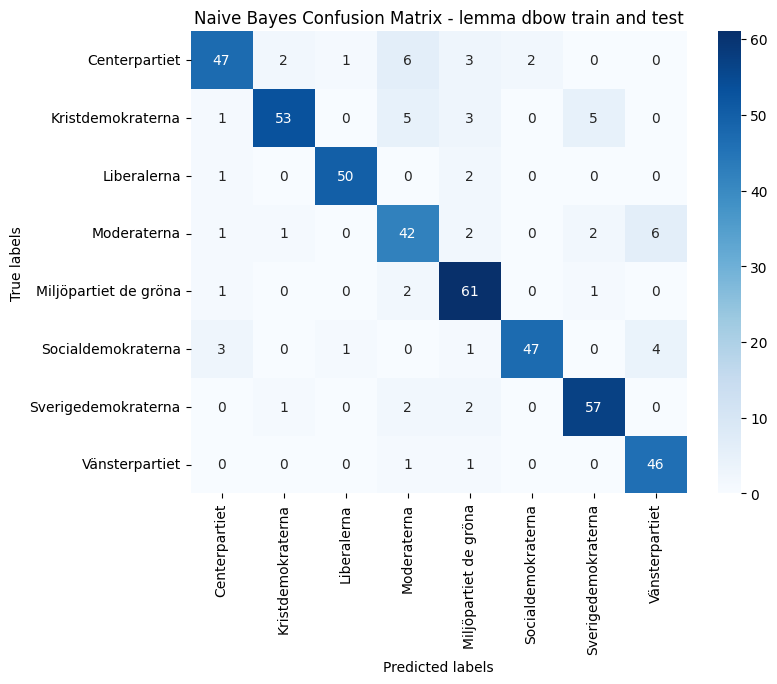



lemma dm train and test Accuracy: 0.7682403433476395

lemma dm train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.71      0.77      0.74        61
    Kristdemokraterna       1.00      0.49      0.66        67
          Liberalerna       1.00      0.72      0.84        53
Miljopartiet de grona       0.64      0.91      0.75        54
          Moderaterna       0.53      0.95      0.68        65
   Socialdemokraterna       0.94      0.80      0.87        56
  Sverigedemokraterna       0.94      0.81      0.87        62
       Vansterpartiet       1.00      0.71      0.83        48

             accuracy                           0.77       466
            macro avg       0.84      0.77      0.78       466
         weighted avg       0.84      0.77      0.77       466



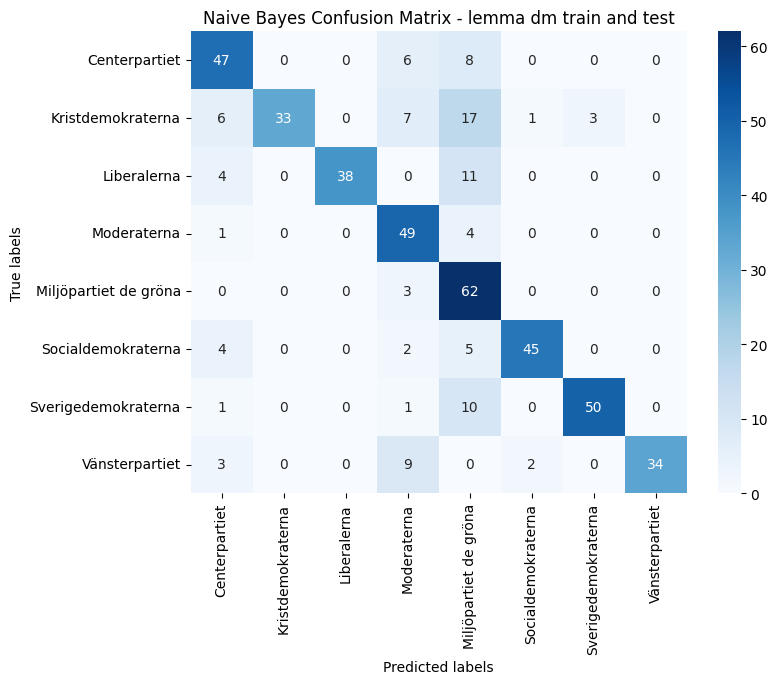

In [ ]:
nb_models = train_and_test_nb(scenarios)

In [ ]:
nb_models

{'nonlemma dbow train and test': GaussianNB(),
 'nonlemma dm train and test': GaussianNB(),
 'lemma dbow train and test': GaussianNB(),
 'lemma dm train and test': GaussianNB()}

comment on nb eval



nonlemma dbow train and test Accuracy: 0.8776824034334764

nonlemma dbow train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.86      0.84      0.85        61
    Kristdemokraterna       0.90      0.78      0.83        67
          Liberalerna       0.94      0.94      0.94        53
Miljopartiet de grona       0.79      0.83      0.81        54
          Moderaterna       0.86      0.83      0.84        65
   Socialdemokraterna       0.91      0.88      0.89        56
  Sverigedemokraterna       0.87      0.97      0.92        62
       Vansterpartiet       0.91      1.00      0.95        48

             accuracy                           0.88       466
            macro avg       0.88      0.88      0.88       466
         weighted avg       0.88      0.88      0.88       466



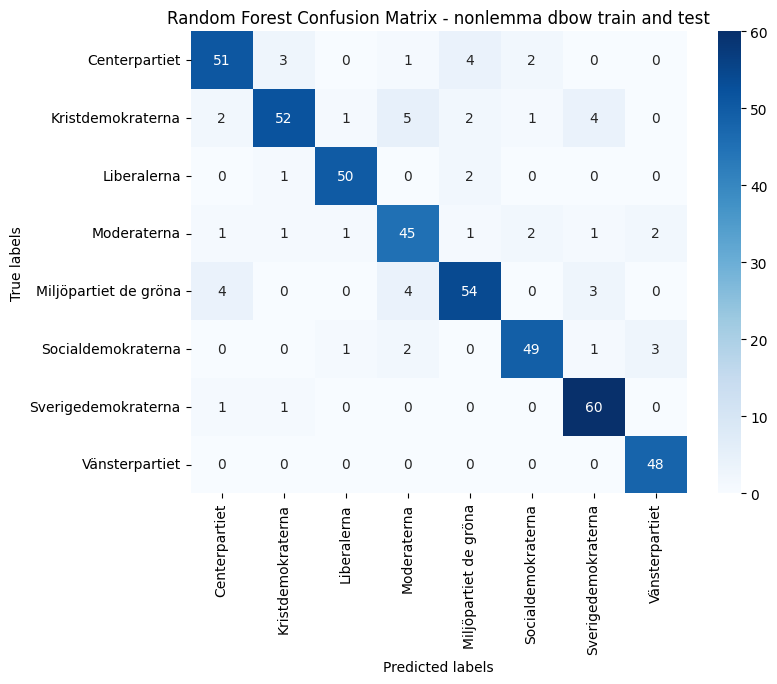



nonlemma dm train and test Accuracy: 0.7682403433476395

nonlemma dm train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.65      0.59      0.62        61
    Kristdemokraterna       0.89      0.63      0.74        67
          Liberalerna       0.97      0.74      0.84        53
Miljopartiet de grona       0.70      0.72      0.71        54
          Moderaterna       0.62      0.85      0.72        65
   Socialdemokraterna       0.88      0.77      0.82        56
  Sverigedemokraterna       0.87      0.95      0.91        62
       Vansterpartiet       0.71      0.94      0.81        48

             accuracy                           0.77       466
            macro avg       0.79      0.77      0.77       466
         weighted avg       0.79      0.77      0.77       466



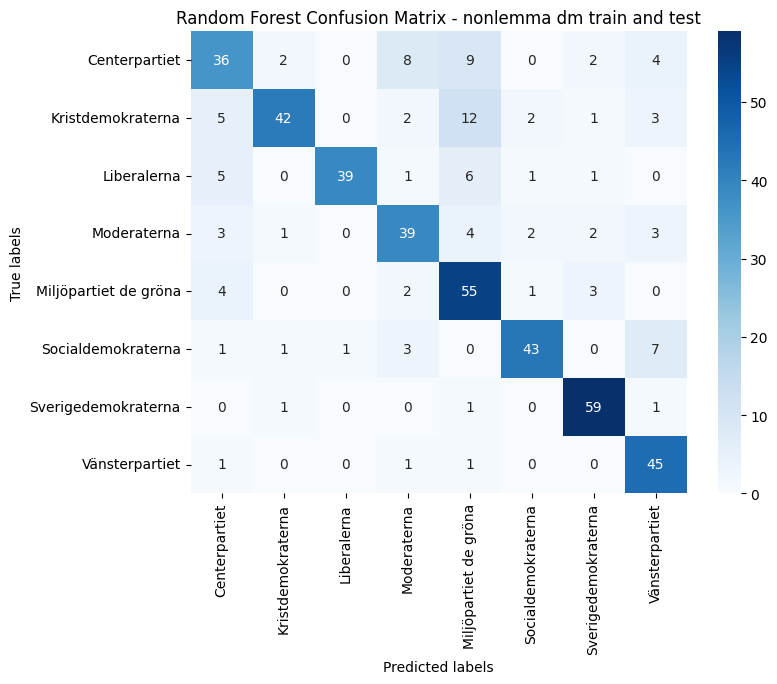



lemma dbow train and test Accuracy: 0.8605150214592274

lemma dbow train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.77      0.82      0.79        61
    Kristdemokraterna       0.95      0.81      0.87        67
          Liberalerna       0.92      0.92      0.92        53
Miljopartiet de grona       0.73      0.67      0.70        54
          Moderaterna       0.86      0.91      0.88        65
   Socialdemokraterna       0.94      0.86      0.90        56
  Sverigedemokraterna       0.91      0.95      0.93        62
       Vansterpartiet       0.81      0.96      0.88        48

             accuracy                           0.86       466
            macro avg       0.86      0.86      0.86       466
         weighted avg       0.86      0.86      0.86       466



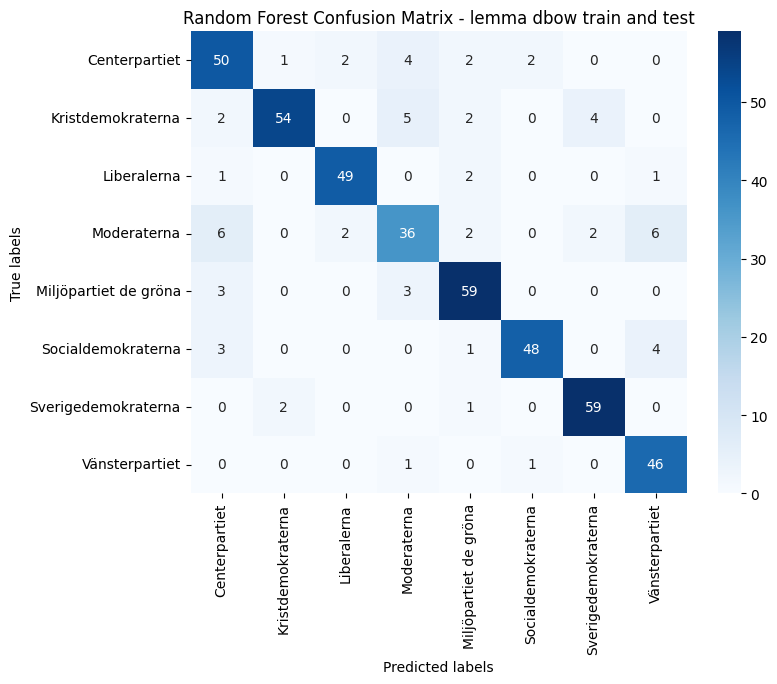



lemma dm train and test Accuracy: 0.778969957081545

lemma dm train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.80      0.61      0.69        61
    Kristdemokraterna       0.87      0.60      0.71        67
          Liberalerna       1.00      0.81      0.90        53
Miljopartiet de grona       0.59      0.85      0.70        54
          Moderaterna       0.70      0.86      0.77        65
   Socialdemokraterna       0.88      0.77      0.82        56
  Sverigedemokraterna       0.73      0.89      0.80        62
       Vansterpartiet       0.88      0.90      0.89        48

             accuracy                           0.78       466
            macro avg       0.81      0.78      0.78       466
         weighted avg       0.80      0.78      0.78       466



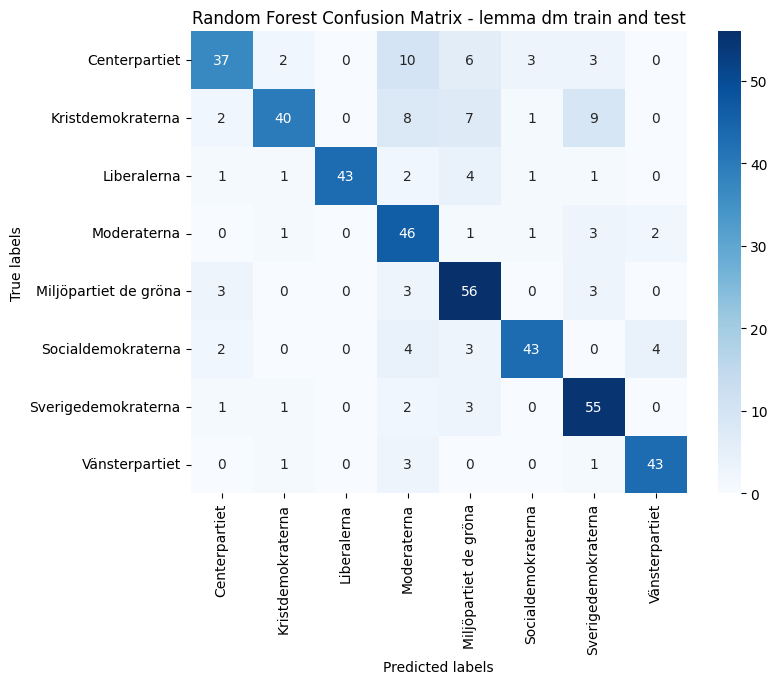

In [ ]:
rf_models = train_and_test_rf(scenarios)

In [ ]:
rf_models

{'nonlemma dbow train and test': RandomForestClassifier(n_estimators=200, random_state=42),
 'nonlemma dm train and test': RandomForestClassifier(n_estimators=200, random_state=42),
 'lemma dbow train and test': RandomForestClassifier(n_estimators=200, random_state=42),
 'lemma dm train and test': RandomForestClassifier(n_estimators=200, random_state=42)}

Comment on rf eval

15/15 [==============================] - 0s 1ms/step


nonlemma dbow train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.90      0.90      0.90        61
    Kristdemokraterna       0.95      0.78      0.85        67
          Liberalerna       0.84      0.98      0.90        53
Miljopartiet de grona       0.84      0.76      0.80        54
          Moderaterna       0.89      0.85      0.87        65
   Socialdemokraterna       0.96      0.80      0.87        56
  Sverigedemokraterna       0.78      0.95      0.86        62
       Vansterpartiet       0.87      0.98      0.92        48

             accuracy                           0.87       466
            macro avg       0.88      0.87      0.87       466
         weighted avg       0.88      0.87      0.87       466



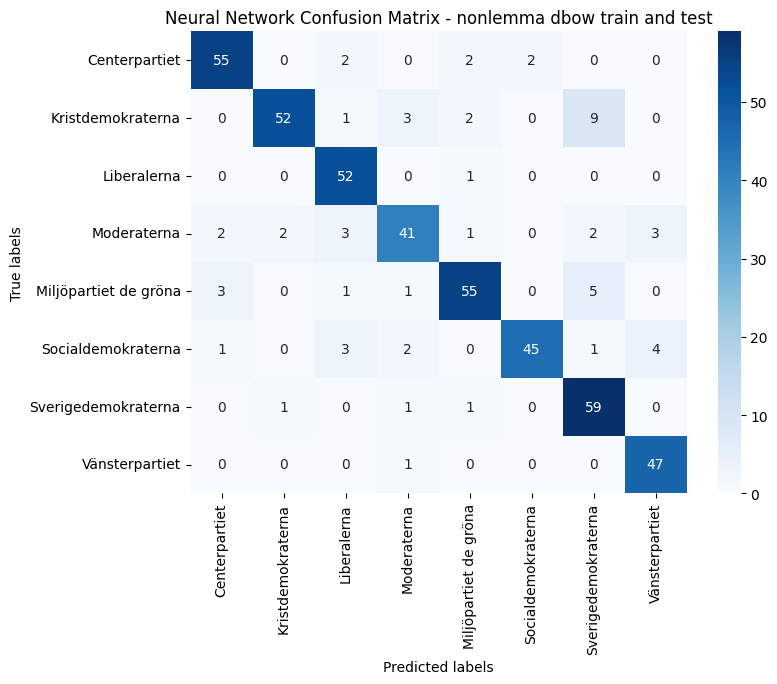

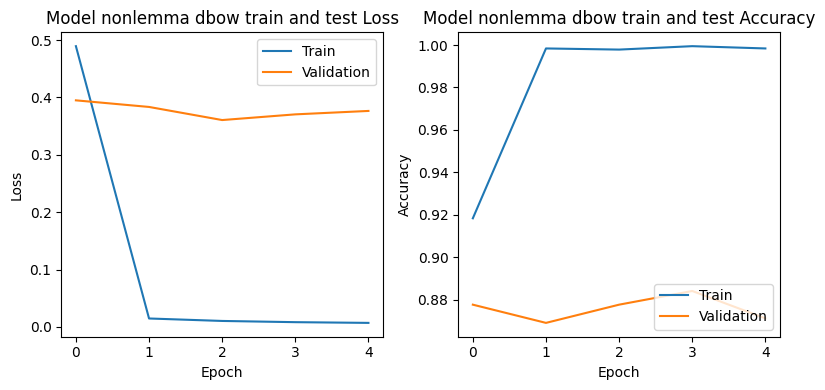



nonlemma dm train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.86      0.61      0.71        61
    Kristdemokraterna       0.85      0.76      0.80        67
          Liberalerna       0.82      0.92      0.87        53
Miljopartiet de grona       0.66      0.74      0.70        54
          Moderaterna       0.81      0.85      0.83        65
   Socialdemokraterna       0.96      0.77      0.85        56
  Sverigedemokraterna       0.88      0.95      0.91        62
       Vansterpartiet       0.74      0.96      0.84        48

             accuracy                           0.82       466
            macro avg       0.82      0.82      0.81       466
         weighted avg       0.82      0.82      0.81       466



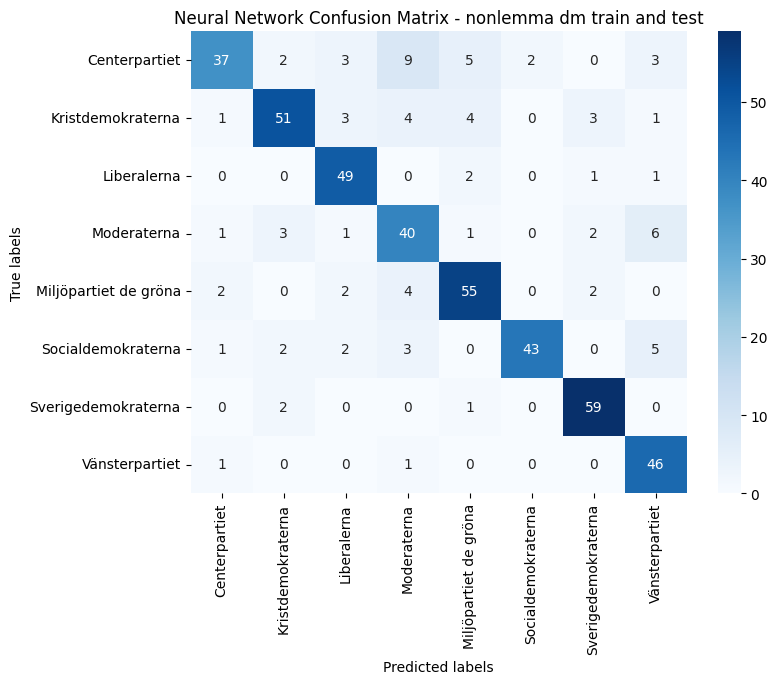

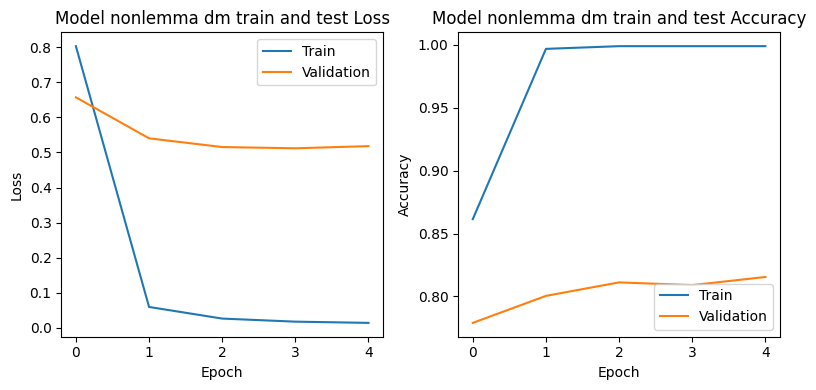



lemma dbow train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.91      0.80      0.85        61
    Kristdemokraterna       0.93      0.78      0.85        67
          Liberalerna       0.96      0.96      0.96        53
Miljopartiet de grona       0.66      0.76      0.71        54
          Moderaterna       0.92      0.92      0.92        65
   Socialdemokraterna       0.92      0.82      0.87        56
  Sverigedemokraterna       0.89      0.95      0.92        62
       Vansterpartiet       0.80      1.00      0.89        48

             accuracy                           0.87       466
            macro avg       0.87      0.87      0.87       466
         weighted avg       0.88      0.87      0.87       466



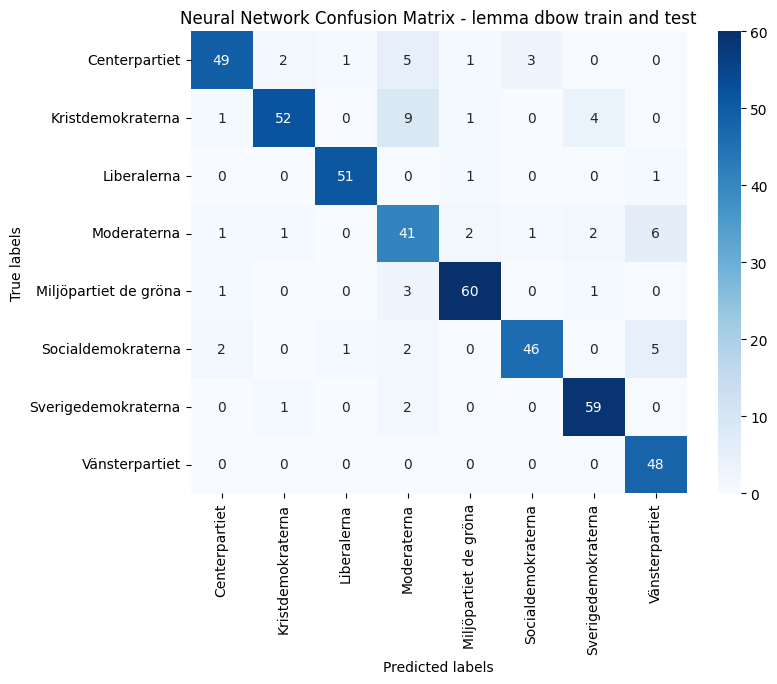

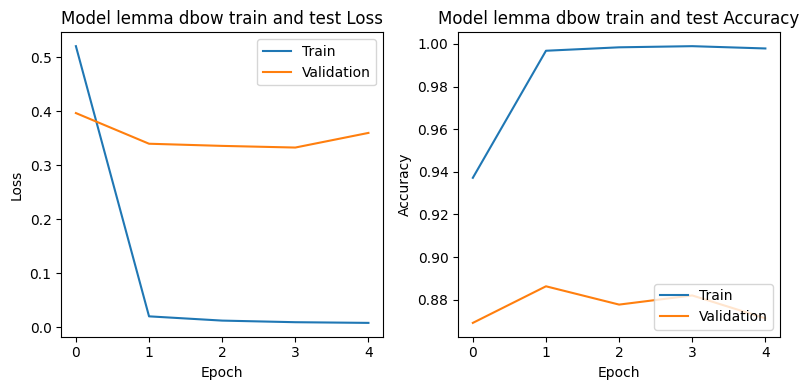



lemma dm train and test Classification Report:
                       precision    recall  f1-score   support

        Centerpartiet       0.83      0.72      0.77        61
    Kristdemokraterna       0.82      0.79      0.80        67
          Liberalerna       0.94      0.92      0.93        53
Miljopartiet de grona       0.79      0.70      0.75        54
          Moderaterna       0.83      0.91      0.87        65
   Socialdemokraterna       0.94      0.88      0.91        56
  Sverigedemokraterna       0.84      0.92      0.88        62
       Vansterpartiet       0.82      0.98      0.90        48

             accuracy                           0.85       466
            macro avg       0.85      0.85      0.85       466
         weighted avg       0.85      0.85      0.85       466



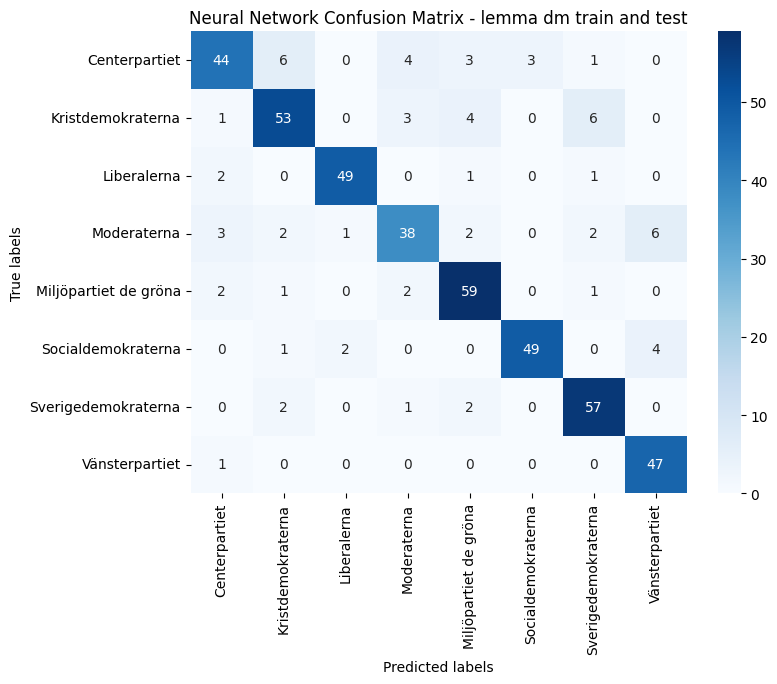

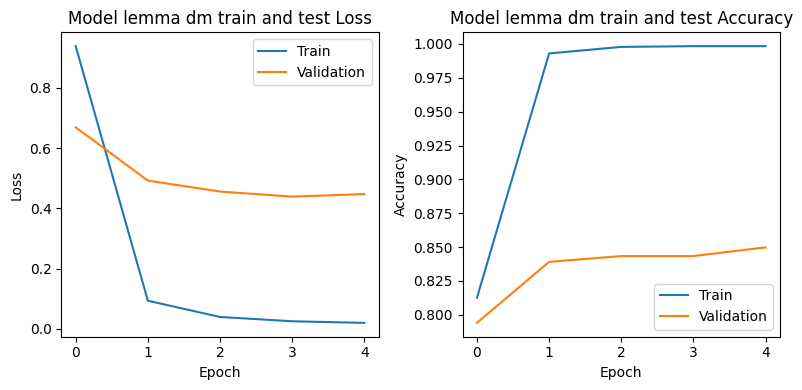

In [ ]:
nn_models_and_decoders = train_and_test_nn(scenarios, epochs=5)

In [ ]:
nn_models_and_decoders

{'nonlemma dbow train and test': [<keras.src.engine.sequential.Sequential at 0x7fa17010f430>,
  LabelEncoder()],
 'nonlemma dm train and test': [<keras.src.engine.sequential.Sequential at 0x7fa1bbe0ff40>,
  LabelEncoder()],
 'lemma dbow train and test': [<keras.src.engine.sequential.Sequential at 0x7fa13509f9d0>,
  LabelEncoder()],
 'lemma dm train and test': [<keras.src.engine.sequential.Sequential at 0x7fa13505ea40>,
  LabelEncoder()]}

# Demo

The demo part allows for any given text to be classified by any given model trained on any of the scenarios. The models can be changed by specifying nb_models, rf_models, and nn_models using the keys. The keys are: 'nonlemma dbow train and test', 'nonlemma dm train and test' , 'lemma dbow train and test', and 'lemma dm train and test'. Two randomly chosen excerpts from the party platforms of the 2020 US election have been translated and listed below. US party platforms can be found [here](https://www.presidency.ucsb.edu/documents/app-categories/elections-and-transitions/party-platforms).
It is possible to write any text to try in the demo. Our models are only trained to classify a text as belonging to one of the eight Swedish parties. This means that any given text will give a classification however it is more meaningfull to do so on a text which is known to be of political origin. The probability distribution for Naive Bayes is not printed since it is almost always 100% for one party.

In [ ]:
rand_dem = 'Demokraterna kommer att återuppliva samhällspolisens tillvägagångssätt, så att tjänstemän på rytmen bättre betjänar kvarteren de arbetar i, och gör smarta investeringar för att uppmuntra avdelningar att bygga effektiva partnerskap med socialarbetare och rådgivare för mental hälsa och missbruk för att hjälpa till att svara på folkhälsoutmaningar. Kroppskameror är inget universalmedel, men demokraterna tror att de kan bidra till att förbättra ansvarsskyldigheten och transparensen; vi stöder deras fortsatta användning och kommer att vidta åtgärder för att förbättra efterlevnaden, kräva att de används i blandade federala-lokala arbetsgrupper och promulgera bästa praxis för att skydda den personliga integriteten. Demokrater tror att krigsvapen inte har någon plats på våra gator och kommer återigen att begränsa försäljningen och överföringen av överskott av militära vapen till inhemska brottsbekämpande myndigheter – en politik som president Trump ändrade omedelbart när han tillträdde. Vi kan inte skapa förtroende utan att hålla makthavarna ansvariga för sina handlingar. Demokraterna kommer att återuppliva mönster-eller praxisutredningar av polisens oredlighet vid justitiedepartementet, och stärka dem genom nya stämningsbefogenheter och utökad tillsyn för att ta itu med systemiska missförhållanden från åklagare. Alldeles för ofta har lagen skyddat poliser som står anklagade för avskyvärda kränkningar av medborgerliga och mänskliga rättigheter. Demokrater stöder en sänkning av avsiktsstandarden för federalt åtal för brottsbekämpande tjänstemän för kränkningar av medborgerliga rättigheter. Vi kommer också att agera för att säkerställa att offer för maktmissbruk från federala, statliga eller lokala myndigheter kan söka rättvisa genom civilrättsliga tvister genom att tygla doktrinen om kvalificerad immunitet.'
rand_rep = 'Förbättra den federala arbetsstyrkan Vi erkänner engagemanget hos de flesta anställda i den federala regeringen och tackar dem för deras service, med särskilt beröm för de whistleblowers som riskerar sina karriärer för att avslöja slöseri, bedrägerier och maktmissbruk. Ingen av dem ska någonsin tvingas gå med i ett fackförbund eller betala avgifter till det. I rättvisans namn mot sina arbetskamrater bör fackliga företrädare inte tillåtas engagera sig i fackliga aktiviteter när de är på allmänhetens tid. Federala chefers oförmåga att disciplinera och vid behov avskeda problempersonal är en skymf mot varje samvetsgrann arbetare, liksom missbruket av medel för påkostade konferenser och rutinmässiga bonusar. De utsedda till en republikansk president kommer att arbeta med karriärchefer för att få slut på dessa övergrepp och genomdriva höga standarder för alla federala anställda. Vi bekräftar de befintliga skydden som ger alla anställda i den federala regeringen möjlighet att fullfölja sin önskan att tjäna sitt land fritt från diskriminering. Vi efterlyser förnyade ansträngningar för att minska, snarare än att utöka, regeringsansvar, och vi uppmanar till särskild uppmärksamhet åt departementens och byråernas uppsvällda PR-budgetar. Den federala regeringen spenderar för mycket av folkets pengar på att tala om för folket vad de borde göra.'

demo_text = rand_rep

# Use lemma True or False depending on model choice
cleaned_demo_text = clean(demo_text, lemma=True, wc=False)

# Choose lemma_models if lemma, or nonlemma_models if nonlemma, [0] == dbow, [1] == dm
demo_vector = lemma_models[0].infer_vector(cleaned_demo_text, epochs=20)

demo_vector_reshaped = demo_vector.reshape(1, -1)

# Choose the desired model with specified key, for Neural Network the decoder must also be specified
nb_demo_pred, nb_demo_pred_proba = test_nb(nb_models['lemma dbow train and test'], demo_vector_reshaped, demo=True)
rf_demo_pred, rf_demo_pred_proba = test_rf(rf_models['lemma dbow train and test'], demo_vector_reshaped, demo=True)
nn_demo_pred, nn_demo_pred_proba = test_nn(nn_models_and_decoders['lemma dbow train and test'][0],
        nn_models_and_decoders['lemma dbow train and test'][1],
        demo_vector_reshaped, demo=True)


print('\nNaive Bayes Prediction:', nb_demo_pred)

print('\nRandom Forest Prediction:', rf_demo_pred)

prediction_probabilities = [(party, rf_demo_pred_proba[i][0]) for i, party in enumerate(PARTIES_TO_KEEP)]

table_headers = ['Party', 'Probability']
table_data = prediction_probabilities
print(tabulate(table_data, headers=table_headers, tablefmt='fancygrid'))

print('\nNeural Network prediction:', nn_demo_pred)

prediction_probabilities = [(party, nn_demo_pred_proba[i][0].round(3)) for i, party in enumerate(PARTIES_TO_KEEP)]

table_headers = ['Party', 'Probability']
table_data = prediction_probabilities
print(tabulate(table_data, headers=table_headers, tablefmt='fancygrid'))

1/1 [==============================] - 0s 24ms/step

Naive Bayes Prediction: Sverigedemokraterna

Random Forest Prediction: Sverigedemokraterna
Party                    Probability
---------------------  -------------
Centerpartiet                  0.055
Kristdemokraterna              0.02
Liberalerna                    0.065
Moderaterna                    0.1
Miljöpartiet de gröna          0.025
Socialdemokraterna             0.19
Sverigedemokraterna            0.405
Vänsterpartiet                 0.14

Neural Network prediction: Sverigedemokraterna
Party                    Probability
---------------------  -------------
Centerpartiet                  0.001
Kristdemokraterna              0.008
Liberalerna                    0.004
Moderaterna                    0.031
Miljöpartiet de gröna          0.001
Socialdemokraterna             0.004
Sverigedemokraterna            0.795
Vänsterpartiet                 0.156
